In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Gathering Dataset

In [ ]:
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""
!kaggle datasets download saurabhshahane/seoul-bike-sharing-demand-prediction
!unzip seoul-bike-sharing-demand-prediction.zip

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/seoul-bike-sharing-demand-prediction
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/126k [00:00<?, ?B/s]
100% 126k/126k [00:00<00:00, 312MB/s]
Archive:  seoul-bike-sharing-demand-prediction.zip
  inflating: SeoulBikeData.csv       


In [ ]:
data = pd.read_csv("/content/SeoulBikeData.csv", encoding='iso-8859-1')

In [ ]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [ ]:
data.isnull().sum()

,0
Date,0
Rented Bike Count,0
Hour,0
Temperature(°C),0
Humidity(%),0
Wind speed (m/s),0
Visibility (10m),0
Dew point temperature(°C),0
Solar Radiation (MJ/m2),0
Rainfall(mm),0


In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# EDA

In [ ]:
data.describe()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


<Axes: xlabel='Rented Bike Count'>

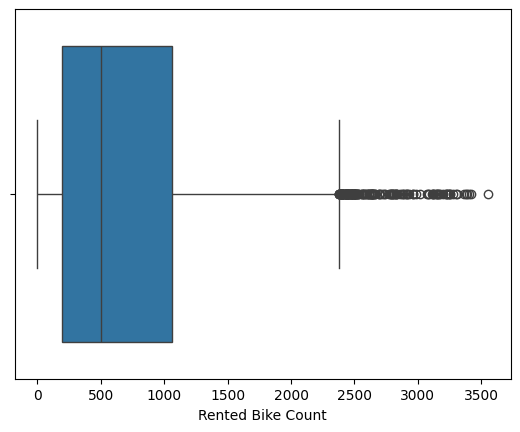

In [ ]:
sns.boxplot(x=data['Rented Bike Count'])

## Rented Bike Count vs Hour


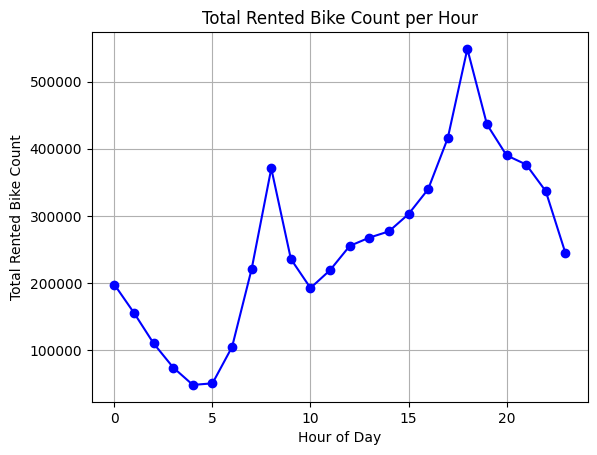

In [ ]:
data_per_hour = data.groupby('Hour')['Rented Bike Count'].sum().reset_index()
plt.plot(data_per_hour['Hour'], data_per_hour['Rented Bike Count'],
         marker="o", color="blue")
plt.title('Total Rented Bike Count per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Rented Bike Count')
plt.grid(True)
plt.show()

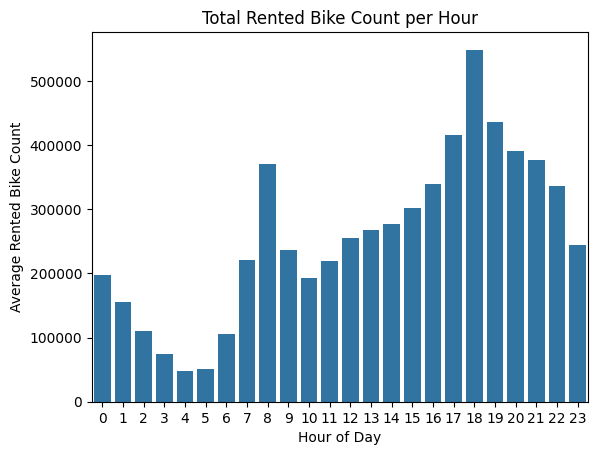

In [ ]:
sns.barplot(data_per_hour, y="Rented Bike Count", x="Hour")
plt.title('Total Rented Bike Count per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rented Bike Count')
plt.show()

In [ ]:
pagi_sibuk = data_per_hour[(data_per_hour['Hour'] >= 7) & (data_per_hour['Hour'] <= 9)]
siang = data_per_hour[(data_per_hour['Hour'] >= 10) & (data_per_hour['Hour'] <= 15)]
sore_sibuk = data_per_hour[(data_per_hour['Hour'] >= 17) & (data_per_hour['Hour'] <= 20)]
malam = data_per_hour[(data_per_hour['Hour'] >= 21) & (data_per_hour['Hour'] <= 23)]

print(f"Total penyewaan di jam 7 - 9 : {pagi_sibuk['Rented Bike Count'].sum()}")
print(f"Total penyewaan di jam 10 - 15 : {siang['Rented Bike Count'].sum()}")
print(f"Total penyewaan di jam 17 - 20: {sore_sibuk['Rented Bike Count'].sum()}")
print(f"Total penyewaan di jam 21 - 23 : {malam['Rented Bike Count'].sum()}")

segemntasi_sewa = {
    '7-9' : pagi_sibuk['Rented Bike Count'].sum(),
    '10-15' : siang['Rented Bike Count'].sum(),
    '17-20' : sore_sibuk['Rented Bike Count'].sum(),
    '21-23' : malam['Rented Bike Count'].sum()
}

print(f"Total penyewaan tertinggi terjadi pada jam {max(segemntasi_sewa, key=segemntasi_sewa.get)}")
print(f"Total penyewaan terendah terjadi pada jam {min(segemntasi_sewa, key=segemntasi_sewa.get)}")

Total penyewaan di jam 7 - 9 : 827707
Total penyewaan di jam 10 - 15 : 1514521
Total penyewaan di jam 17 - 20: 1790525
Total penyewaan di jam 21 - 23 : 958261
Total penyewaan tertinggi terjadi pada jam 17-20
Total penyewaan terendah terjadi pada jam 7-9


## Rented count vs Hour vs Holiday

In [ ]:
# Total penyewa berdasarkan Holiday
total_by_holiday = data.groupby('Holiday')['Rented Bike Count'].sum().reset_index()
total_by_holiday

,Holiday,Rented Bike Count
0,Holiday,215895
1,No Holiday,5956419


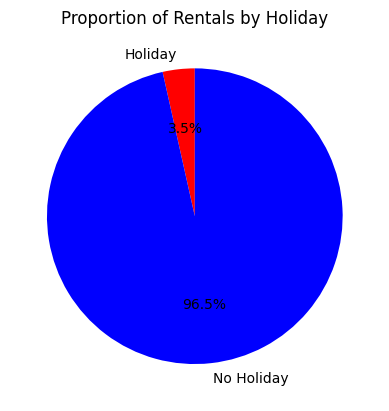

In [ ]:
plt.pie(total_by_holiday['Rented Bike Count'],
        labels=total_by_holiday['Holiday'],
        autopct='%1.1f%%',
        colors=["red","blue"],
        startangle=90)

plt.title("Proportion of Rentals by Holiday")
plt.show()

In [ ]:
# Create dataset where it's holiday or no
data_holiday = data[data['Holiday'] == 'Holiday']
data_no_holiday = data[data['Holiday'] == 'No Holiday']

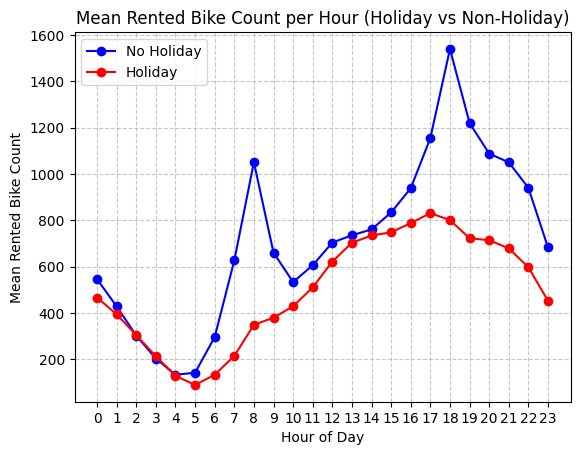

In [ ]:
data_per_hour_holiday = data.groupby(['Hour', 'Holiday'])['Rented Bike Count'].mean().reset_index()
pivot_data = data_per_hour_holiday.pivot(index='Hour', columns='Holiday', values='Rented Bike Count')

# Plot line
plt.plot(pivot_data.index, pivot_data['No Holiday'], marker="o", label="No Holiday", color="blue")
plt.plot(pivot_data.index, pivot_data['Holiday'], marker="o", label="Holiday", color="red")

plt.title('Mean Rented Bike Count per Hour (Holiday vs Non-Holiday)')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Rented Bike Count')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

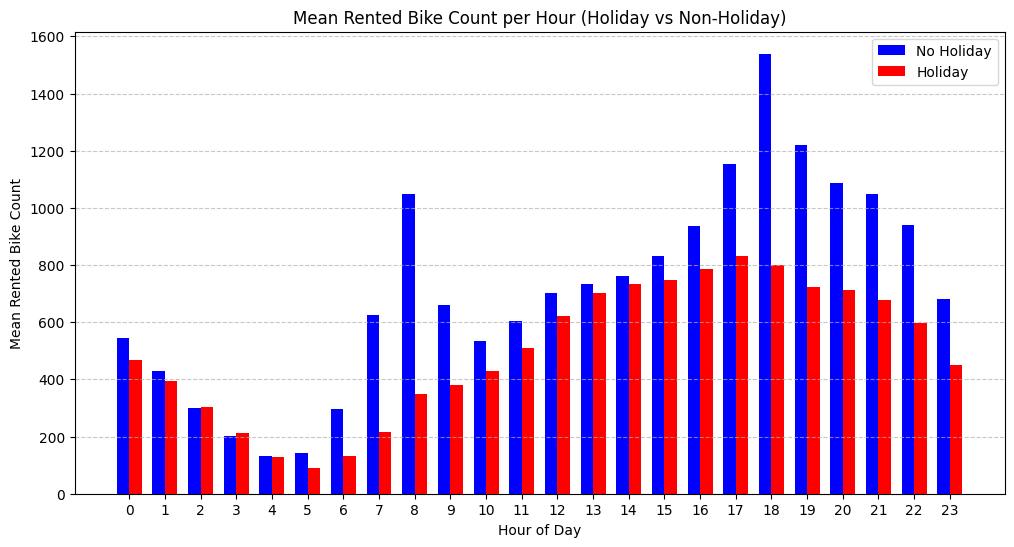

In [ ]:
# Ambil data pivot tadi
x = np.arange(len(pivot_data.index))  # posisi X untuk setiap jam
width = 0.35  # lebar bar

fig, ax = plt.subplots(figsize=(12,6))

# Plot dua bar berdampingan
ax.bar(x - width/2, pivot_data['No Holiday'], width, label="No Holiday", color="blue")
ax.bar(x + width/2, pivot_data['Holiday'], width, label="Holiday", color="red")

ax.set_title('Mean Rented Bike Count per Hour (Holiday vs Non-Holiday)')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Rented Bike Count')
ax.set_xticks(x)
ax.set_xticklabels(pivot_data.index)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Rented count vs Season

In [ ]:
# Total penyewa berdasarkan Season
total_by_season = data.groupby('Seasons')['Rented Bike Count'].sum().reset_index().sort_values(by='Rented Bike Count', ascending=False)
total_by_season

,Seasons,Rented Bike Count
2,Summer,2283234
0,Autumn,1790002
1,Spring,1611909
3,Winter,487169


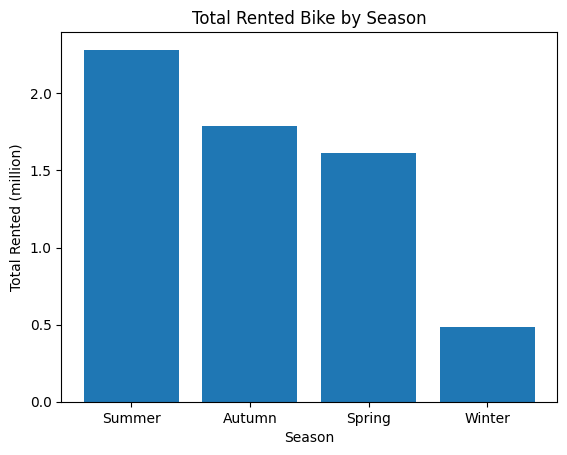

In [ ]:
from matplotlib.ticker import FuncFormatter

def juta(x, pos):
    return f'{x/1_000_000:.1f}'  # contoh: 2,5 jt

# Create the bar plot
plt.bar(total_by_season['Seasons'], total_by_season['Rented Bike Count'])
# Add labels and title for clarity
plt.xlabel('Season')
plt.ylabel('Total Rented (million)')
plt.title('Total Rented Bike by Season')
# Terapkan formatter di sumbu Y
plt.gca().yaxis.set_major_formatter(FuncFormatter(juta))

# Display the plot
plt.show()

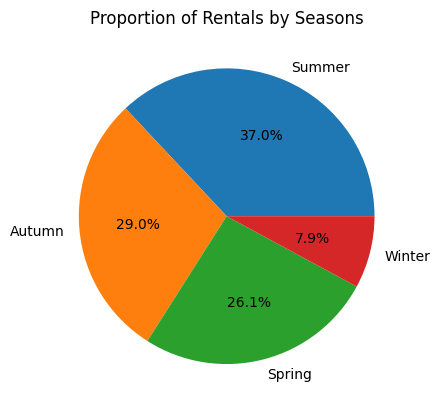

In [ ]:
plt.pie(total_by_season['Rented Bike Count'],
        labels=total_by_season['Seasons'],
        autopct='%1.1f%%')

plt.title("Proportion of Rentals by Seasons")
plt.show()

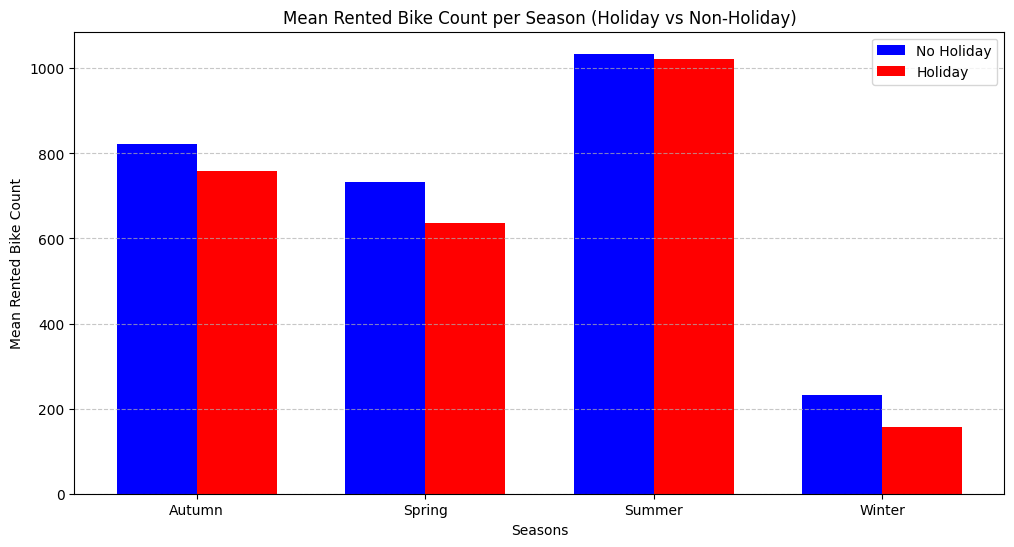

In [ ]:
data_season_holiday = data.groupby(['Seasons', 'Holiday'])['Rented Bike Count'].mean().reset_index()
pivot_data_season = data_season_holiday.pivot(index='Seasons', columns='Holiday', values='Rented Bike Count')

x = np.arange(len(pivot_data_season.index))  # posisi X untuk setiap jam
width = 0.35  # lebar bar

fig, ax = plt.subplots(figsize=(12,6))

# Plot dua bar berdampingan
ax.bar(x - width/2, pivot_data_season['No Holiday'], width, label="No Holiday", color="blue")
ax.bar(x + width/2, pivot_data_season['Holiday'], width, label="Holiday", color="red")

ax.set_title('Mean Rented Bike Count per Season (Holiday vs Non-Holiday)')
ax.set_xlabel('Seasons')
ax.set_ylabel('Mean Rented Bike Count')
ax.set_xticks(x)
ax.set_xticklabels(pivot_data_season.index)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
pivot_data_season

Holiday,Holiday,No Holiday
Seasons,,
Autumn,758.483333,823.151163
Spring,635.305556,733.224251
Summer,1022.145833,1034.338426
Winter,156.625000,232.264736


## Correlation Numerical Features

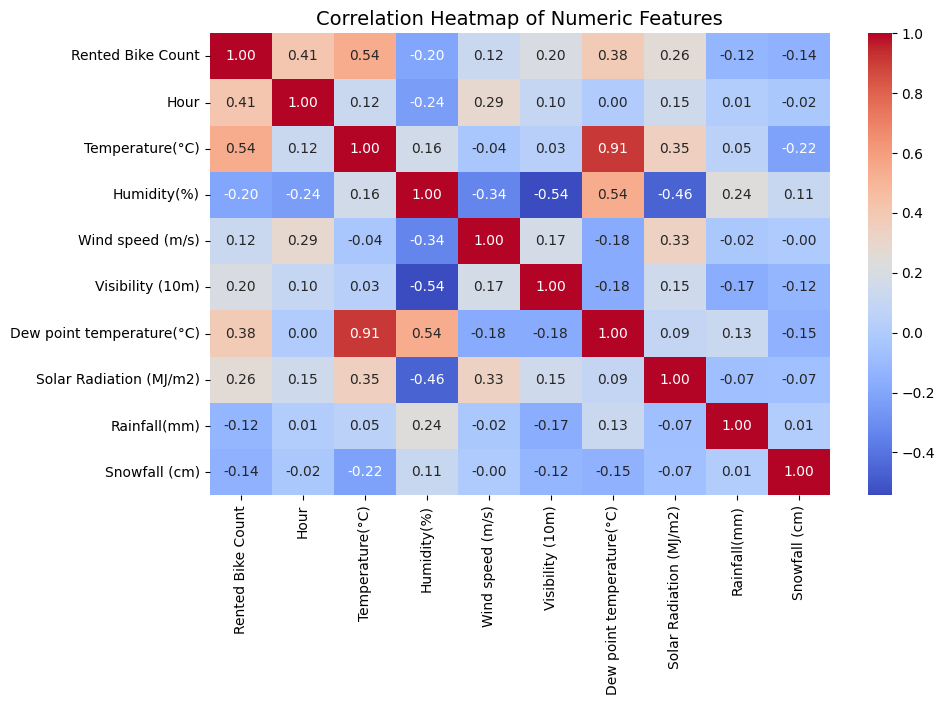

In [ ]:
data_numerical = data.select_dtypes(include=np.number).corr()
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data_numerical, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

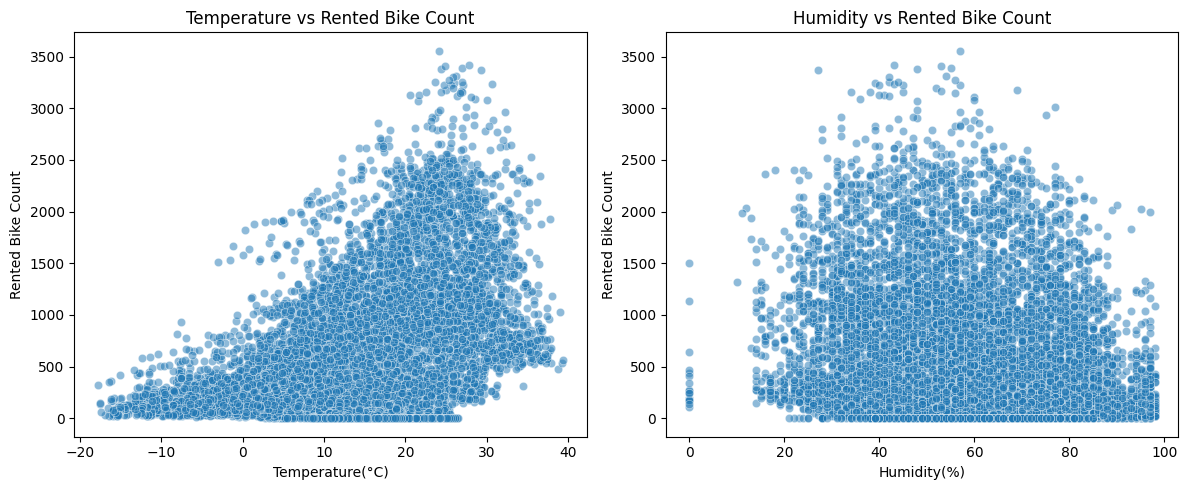

In [ ]:
# Atur ukuran figure
plt.figure(figsize=(12, 5))

# Scatterplot 1: Temperature vs Rented Bike Count
plt.subplot(1, 2, 1)  # (rows, cols, index)
sns.scatterplot(x="Temperature(°C)", y="Rented Bike Count", data=data, alpha=0.5)
plt.title("Temperature vs Rented Bike Count")

# Scatterplot 2: Humidity vs Rented Bike Count
plt.subplot(1, 2, 2)
sns.scatterplot(x="Humidity(%)", y="Rented Bike Count", data=data, alpha=0.5)
plt.title("Humidity vs Rented Bike Count")

plt.tight_layout()
plt.show()

## Monthly Trends

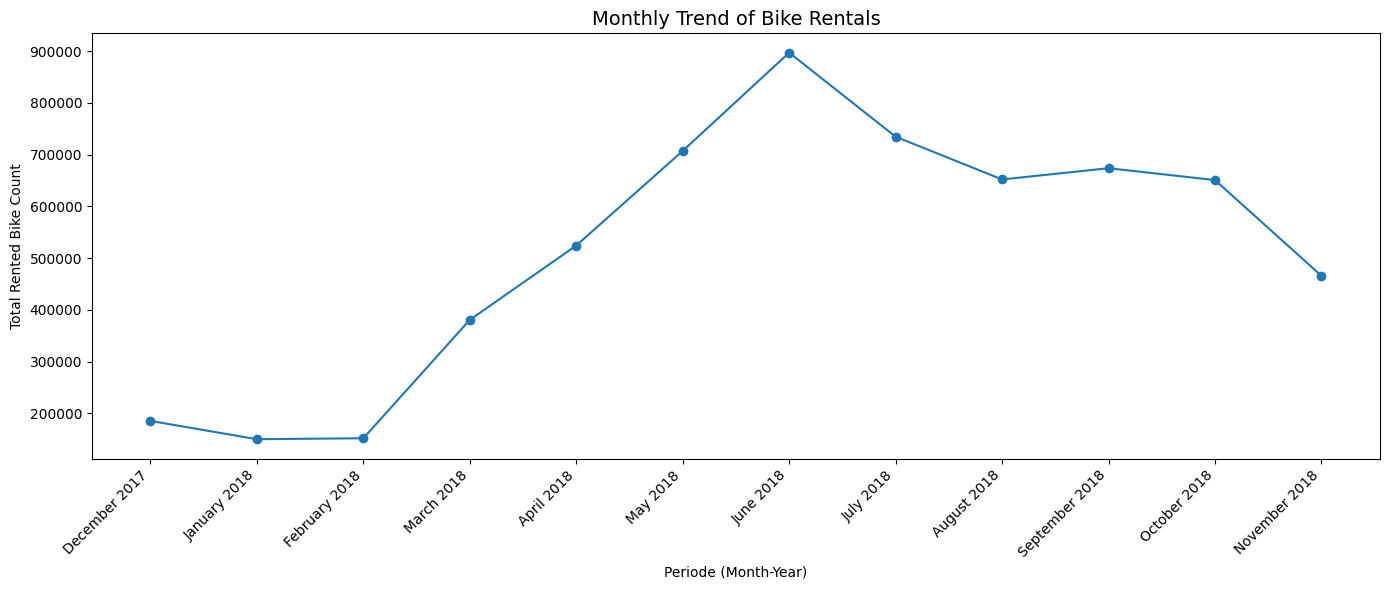

In [ ]:
# Buat kolom baru "periode" dengan format "Month YYYY"
data['Periode'] = data['Date'].dt.strftime('%B %Y')
# Hitung total penyewaan per periode (bulanan)
monthly_trend = data.groupby('Periode')['Rented Bike Count'].sum().reset_index()

# Urutkan berdasarkan tanggal asli (supaya plot tidak acak)
monthly_trend['Date'] = pd.to_datetime(monthly_trend['Periode'])
monthly_trend = monthly_trend.sort_values('Date')

# Plot line chart
plt.figure(figsize=(14, 6))
plt.plot(monthly_trend['Periode'], monthly_trend['Rented Bike Count'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title("Monthly Trend of Bike Rentals", fontsize=14)
plt.xlabel("Periode (Month-Year)")
plt.ylabel("Total Rented Bike Count")
plt.tight_layout()
plt.show()

In [ ]:
monthly_weather = data.groupby('Periode')[['Temperature(°C)', 'Humidity(%)','Rainfall(mm)','Snowfall (cm)','Rented Bike Count']].mean().reset_index()
monthly_weather['Date'] = pd.to_datetime(monthly_weather['Periode'])
monthly_weather = monthly_weather.sort_values('Date')
monthly_weather


,Periode,Temperature(°C),Humidity(%),Rainfall(mm),Snowfall (cm),Rented Bike Count,Date
2,December 2017,-1.928763,55.825269,0.046774,0.370968,249.099462,2017-12-01
4,January 2018,-3.943145,48.081989,0.011425,0.255376,201.620968,2018-01-01
3,February 2018,-1.664732,44.854167,0.041071,0.102083,225.941964,2018-02-01
7,March 2018,8.044489,59.295699,0.069220,0.000000,511.551075,2018-03-01
0,April 2018,12.948056,54.611111,0.180972,0.000000,728.093056,2018-04-01
8,May 2018,18.144355,62.288978,0.298387,0.000000,950.387097,2018-05-01
6,June 2018,23.136806,62.618056,0.238194,0.000000,1245.676389,2018-06-01
5,July 2018,27.763978,67.447581,0.249462,0.000000,987.177419,2018-07-01
1,August 2018,28.736425,64.802419,0.272312,0.000000,876.192204,2018-08-01
11,September 2018,21.498750,60.700000,0.095139,0.000000,935.572222,2018-09-01


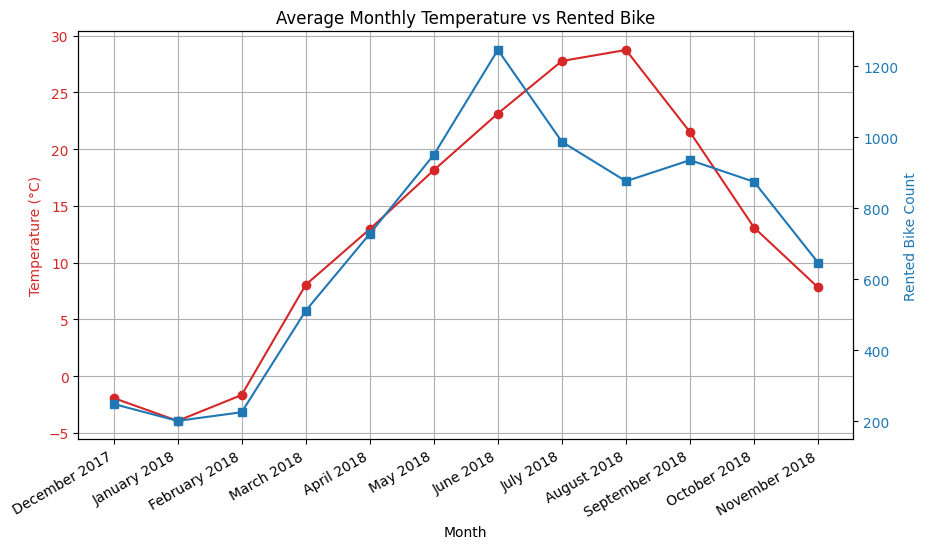

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

# suhu
ax1.plot(monthly_weather['Periode'], monthly_weather['Temperature(°C)'],
         color='tab:red', marker='o', label='Temperature (°C)')
ax1.set_xlabel("Month")
ax1.set_ylabel("Temperature (°C)", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# penyewaan
ax2 = ax1.twinx()
ax2.plot(monthly_weather['Periode'], monthly_weather['Rented Bike Count'],
         color="tab:blue", marker='s', label="Rented Bike Count")
ax2.set_ylabel("Rented Bike Count", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# rapikan
fig.autofmt_xdate()
ax1.grid(True)
plt.title("Average Monthly Temperature vs Rented Bike")
plt.show()

## Day Trends

In [ ]:
# Pastikan 'Periode' sudah bulanan
monthly_holiday_holiday = data.pivot_table(
    index='Periode',
    columns='Holiday',
    values='Rented Bike Count',
    aggfunc='mean'
).reset_index()

# Konversi ke datetime
monthly_holiday_holiday['Date'] = pd.to_datetime(monthly_holiday_holiday['Periode'])
monthly_holiday_holiday = monthly_holiday_holiday.sort_values('Date')

monthly_holiday_holiday

Holiday,Periode,Holiday,No Holiday,Date
2,December 2017,172.781250,260.405864,2017-12-01
4,January 2018,178.750000,202.383333,2018-01-01
3,February 2018,127.708333,237.730000,2018-02-01
7,March 2018,213.833333,521.475000,2018-03-01
0,April 2018,NaN,728.093056,2018-04-01
8,May 2018,846.041667,957.583333,2018-05-01
6,June 2018,1270.750000,1244.811782,2018-06-01
5,July 2018,NaN,987.177419,2018-07-01
1,August 2018,773.541667,879.613889,2018-08-01
11,September 2018,842.625000,945.899691,2018-09-01


In [ ]:
# Tambahkan kolom Hari
data['Days'] = data['Date'].dt.day_name()
data['Weekend'] = np.where(data['Date'].dt.dayofweek >= 5, 'Weekend', 'Weekday')
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Periode,Days,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,December 2017,Friday,Weekday
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,December 2017,Friday,Weekday
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,December 2017,Friday,Weekday
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,December 2017,Friday,Weekday
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,December 2017,Friday,Weekday


analisis selanjutnya berdasarkan weekend (rata-rata) dan membandingkanya dengan holiday

In [ ]:
data.groupby(['Holiday','Weekend'])['Rented Bike Count'].mean().reset_index()

,Holiday,Weekend,Rented Bike Count
0,Holiday,Weekday,557.380952
1,Holiday,Weekend,298.072917
2,No Holiday,Weekday,728.634953
3,No Holiday,Weekend,682.112917


In [ ]:
weekend_dist = data.groupby(['Weekend'])['Rented Bike Count'].sum()
weekend_dist

,Rented Bike Count
Weekend,
Weekday,4506628
Weekend,1665686


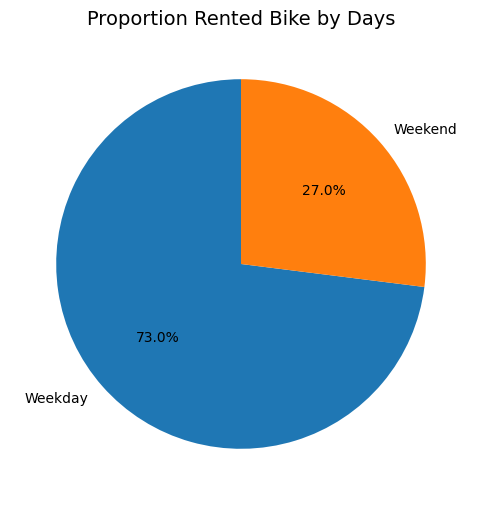

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(
    weekend_dist,
    labels=weekend_dist.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Proportion Rented Bike by Days", fontsize=14)
plt.show()

In [ ]:
hour_weekend = data.groupby(['Hour','Weekend'])['Rented Bike Count'].mean().reset_index()
hour_weekend

,Hour,Weekend,Rented Bike Count
0,0,Weekday,497.731801
1,0,Weekend,651.201923
2,1,Weekday,384.022989
3,1,Weekend,531.990385
4,2,Weekday,262.938697
5,2,Weekend,398.730769
6,3,Weekday,174.555556
7,3,Weekend,275.548077
8,4,Weekday,117.908046
9,4,Weekend,169.442308


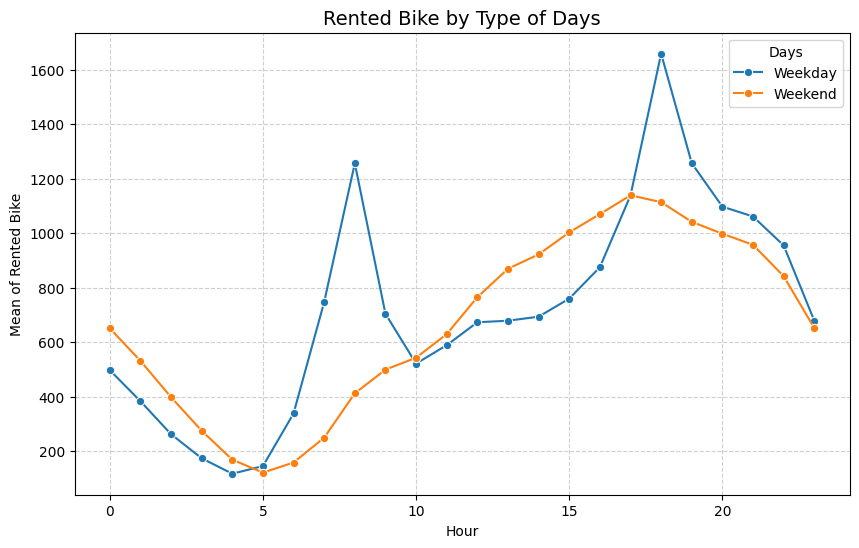

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=hour_weekend,
    x='Hour',
    y='Rented Bike Count',
    hue='Weekend',
    marker='o'
)

plt.title("Rented Bike by Type of Days", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Mean of Rented Bike")
plt.legend(title="Days")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

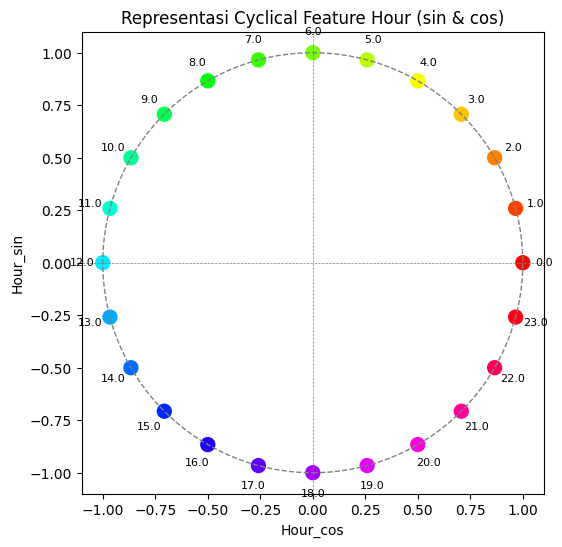

In [ ]:
# Buat dataframe jam 0-23
hours = np.arange(24)
df = pd.DataFrame({
    'Hour': hours,
    'Hour_sin': np.sin(2 * np.pi * hours / 24),
    'Hour_cos': np.cos(2 * np.pi * hours / 24)
})

# Plot unit circle
plt.figure(figsize=(6,6))
plt.scatter(df['Hour_cos'], df['Hour_sin'], c=df['Hour'], cmap='hsv', s=100)

# Tambahkan anotasi jam
for i, row in df.iterrows():
    plt.text(row['Hour_cos']*1.1, row['Hour_sin']*1.1, str(row['Hour']),
             ha='center', va='center', fontsize=8)

# Lingkaran referensi
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.title("Representasi Cyclical Feature Hour (sin & cos)", fontsize=12)
plt.xlabel("Hour_cos")
plt.ylabel("Hour_sin")
plt.show()

## Kesimpulan

* Penyewaan sepeda didominasi oleh aktivitas komuter atau mobilitas. Hal ini berdasarkan aktivitas penyewaan yang tinggi pada pukul 7 - 9 pagi dan pukul 17 - 19 malam
* Penyewaan sepeda di hari kerja (weekday / no holiday) lebih tinggi dibanding weekend atau holiday secara rata-rata. Hal ini menegaskan jika penyewaan sepeda didominasi oleh aktivitas komuter dan penyewaan di hari libur untuk rekreasi atau kegiatan santai.
* Penyewaan sepeda tertinggi terjadi pada musim panas atau Summer (baik holiday atau no holiday) dan Winter mengalami penurunan. Hal ini dimungkinkan karena cuaca cerah dan mendukung aktivitas luar ruangan pada musim panas. Pada musim dingin rata-rata penyewaan lebih rendah secara keseluruhan (menjadi yang paling rendah)
* Penyewaan sepeda dipengaruhi oleh suhu. Semakin hangat suhunya, semakin tinggi demand. Dengan pola ini, strategi marketing dapat difokuskan pada kondisi cuaca yang mendukung penyewaan
* Berdasarkan tren bulanan, jumlah penyewaan menunjukkan pola kenaikan yang signifikan dari Maret - Juni (puncaknya). Setelah itu, tren penyewaan turun bertahap hingga November. Rata-rata penyewaan juga dipengaruhi suhu bulanan. Penyewaan meningkat saat suhu mulai hangat dan puncaknya pada suhu sekitar 20-25 dan kembali turun saat suhunya panas atau dingin. Tren bulanan penyewaan sangat dipengaruhi oleh kondisi suhu. Cuaca yang hangat mendorong peningkatan aktivitas bersepeda, sedangkan cuaca dingin cenderung menurunkan minat penyewaan
* Sebagian besar penyewaan sepeda terjadi pada weekday (sekitar 73%), dengan pola jam sibuk pagi dan sore yang menunjukkan sepeda digunakan terutama untuk aktivitas rutin seperti berangkat dan pulang kerja/kuliah. Sebaliknya, pada weekend penyewaan lebih sedikit (27%) tetapi tersebar merata sepanjang hari, mencerminkan penggunaan untuk rekreasi atau aktivitas santai.

## Action Plan


* Membuat promosi atau kampanye "Bike to Work"  atau diskon di jam sibuk
* Memastikan sepeda tersedia lebih banyak di jam sibuk, area perkantoran, atau jalur utaman transportasi publik. Hari libur bisa difokuskan ke area wisata, taman, atau pusat rekreasi
* Melakukan promosi pada musim panas karena momen terbaik dimana permintaan tinggi. Pada musim gugur atau semi tetap optimalkan layanan dan strategi khusus untuk menarik pelanggan rekreasi di hari libur. Pada musim dingin lebih menawarkan promosi dengan cara integrasi ke transum. Efisiensi operasional juga dapat dilakukan di musim dingin

# Data Preparation

In [ ]:
# drop baris dengan nilai "No" pada kolom "Functioning Day"
data_model = data[data['Functioning Day'] != "No"].copy()

In [ ]:
data_model['Hour_sin'] = np.sin(2 * np.pi * data_model['Hour'] / 24)
data_model['Hour_cos'] = np.cos(2 * np.pi * data_model['Hour'] / 24)

# Tambahkan kolom Hari
data_model['Days'] = data_model['Date'].dt.day_name()
data_model['Weekend'] = np.where(data_model['Date'].dt.dayofweek >= 5, 'Weekend', 'Weekday')


# Buat kolom biner apakah ada presipitasi (rain atau snow)
data_model['Precipitation'] = ((data_model['Rainfall(mm)'] > 0) | (data_model['Snowfall (cm)'] > 0)).astype(int)

In [ ]:
data_model

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Hour_sin,Hour_cos,Days,Weekend,Precipitation
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.000000,1.000000,Friday,Weekday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.258819,0.965926,Friday,Weekday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,0.500000,0.866025,Friday,Weekday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.707107,0.707107,Friday,Weekday,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.866025,0.500000,Friday,Weekday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,-0.965926,0.258819,Friday,Weekday,0
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,-0.866025,0.500000,Friday,Weekday,0
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,-0.707107,0.707107,Friday,Weekday,0
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,-0.500000,0.866025,Friday,Weekday,0


In [ ]:
# Total baris
total_rows = len(data_model)

# Jumlah baris dengan penyewaan > 2500
outlier_rows = (data_model['Rented Bike Count'] > 2500).sum()

# Proporsi (%)
proporsi = (outlier_rows / total_rows) * 100

print("Total data:", total_rows)
print("Jumlah data > 2500:", outlier_rows)
print(f"Proporsi: {proporsi:.2f}%")

Total data: 8465
Jumlah data > 2500: 97
Proporsi: 1.15%


In [ ]:
data_model[data_model['Precipitation'] == 1]

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Periode,Hour_sin,Hour_cos,Days,Weekend,Precipitation
51,2017-12-03,117,3,3.4,71,1.6,1011,-1.3,0.00,0.5,0.0,Winter,No Holiday,Yes,December 2017,0.707107,7.071068e-01,Sunday,Weekend,1
54,2017-12-03,13,6,3.4,86,2.5,278,1.2,0.00,1.0,0.0,Winter,No Holiday,Yes,December 2017,1.000000,6.123234e-17,Sunday,Weekend,1
57,2017-12-03,152,9,3.5,91,1.8,231,2.1,0.02,2.5,0.0,Winter,No Holiday,Yes,December 2017,0.707107,-7.071068e-01,Sunday,Weekend,1
78,2017-12-04,200,6,1.2,76,3.7,371,-2.5,0.00,0.1,0.0,Winter,No Holiday,Yes,December 2017,1.000000,6.123234e-17,Monday,Weekday,1
120,2017-12-06,145,0,-2.8,77,0.0,331,-6.2,0.00,0.1,0.1,Winter,No Holiday,Yes,December 2017,0.000000,1.000000e+00,Wednesday,Weekday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8645,2018-11-26,115,5,2.1,88,1.4,323,0.3,0.00,0.0,0.3,Autumn,No Holiday,Yes,November 2018,0.965926,2.588190e-01,Monday,Weekday,1
8646,2018-11-26,339,6,1.8,88,1.1,313,0.0,0.00,0.0,0.3,Autumn,No Holiday,Yes,November 2018,1.000000,6.123234e-17,Monday,Weekday,1
8647,2018-11-26,819,7,1.7,89,1.3,295,0.0,0.00,0.0,0.3,Autumn,No Holiday,Yes,November 2018,0.965926,-2.588190e-01,Monday,Weekday,1
8648,2018-11-26,1524,8,2.0,84,1.1,396,-0.4,0.03,0.0,0.3,Autumn,No Holiday,Yes,November 2018,0.866025,-5.000000e-01,Monday,Weekday,1


In [ ]:
data_model.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Hour_sin,Hour_cos,Days,Weekend,Precipitation
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.000000,1.000000,Friday,Weekday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.258819,0.965926,Friday,Weekday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,0.500000,0.866025,Friday,Weekday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.707107,0.707107,Friday,Weekday,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.866025,0.500000,Friday,Weekday,0


In [ ]:
data_model = data_model.drop(['Date','Wind speed (m/s)','Visibility (10m)','Dew point temperature(°C)','Solar Radiation (MJ/m2)',
                 'Rainfall(mm)','Snowfall (cm)','Functioning Day','Periode','Days','Hour'], axis=1)
data_model

,Rented Bike Count,Temperature(°C),Humidity(%),Seasons,Holiday,Hour_sin,Hour_cos,Weekend,Precipitation
0,254,-5.2,37,Winter,No Holiday,0.000000,1.000000,Weekday,0
1,204,-5.5,38,Winter,No Holiday,0.258819,0.965926,Weekday,0
2,173,-6.0,39,Winter,No Holiday,0.500000,0.866025,Weekday,0
3,107,-6.2,40,Winter,No Holiday,0.707107,0.707107,Weekday,0
4,78,-6.0,36,Winter,No Holiday,0.866025,0.500000,Weekday,0
...,...,...,...,...,...,...,...,...,...
8755,1003,4.2,34,Autumn,No Holiday,-0.965926,0.258819,Weekday,0
8756,764,3.4,37,Autumn,No Holiday,-0.866025,0.500000,Weekday,0
8757,694,2.6,39,Autumn,No Holiday,-0.707107,0.707107,Weekday,0
8758,712,2.1,41,Autumn,No Holiday,-0.500000,0.866025,Weekday,0


In [ ]:
data_model.columns

Index(['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Seasons',
       'Holiday', 'Hour_sin', 'Hour_cos', 'Weekend', 'Precipitation'],
      dtype='object')

# Modeling

In [ ]:
# Pilih X dan y ===
X = data_model.drop(['Rented Bike Count'], axis=1)
y = data_model['Rented Bike Count']

# Train-test split (hanya X dan y) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Transformasi log target (baru dilakukan setelah split) ===
y_log_train = np.log1p(y_train)  # log transform di train
y_log_test  = np.log1p(y_test)   # log transform di test

In [ ]:
# Tentukan kolom categorical & numerical ===
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int','float']).columns

In [ ]:
numerical_features

Index(['Temperature(°C)', 'Humidity(%)', 'Hour_sin', 'Hour_cos',
       'Precipitation'],
      dtype='object')

In [ ]:
# Preprocessing pipeline ===
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())     # standardisasi numeric
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))   # OneHot untuk categorical
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# Definisi pipeline model ===
# Linear Regression
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Random Forest
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# === 7. Training ===
model_lr.fit(X_train, y_log_train)   # pakai target log
model_rf.fit(X_train, y_train)       # pakai target asli

# === 8. Prediksi ===
y_pred_lr = np.expm1(model_lr.predict(X_test))  # inverse log
y_pred_rf = model_rf.predict(X_test)

#Evaluasi ===
def evaluate(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²   :", r2_score(y_true, y_pred))
    print()

evaluate(y_test, y_pred_lr, "Linear Regression (log target)")
evaluate(y_test, y_pred_rf, "Random Forest")


=== Linear Regression (log target) ===
MAE : 285.3422421617598
RMSE: 441.30633339925083
R²   : 0.5143516925959073

=== Random Forest ===
MAE : 114.9620993391451
RMSE: 195.7485518407883
R²   : 0.9044482435932908



In [ ]:
# pipeline dengan XGBoost
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# training
xgb_pipeline.fit(X_train, y_train)

# prediksi (ingat: hasil masih di log scale, harus inverse transform)
y_pred_log = xgb_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # balik dari log(1+y) ke skala asli

# evaluasi
mae_xgboost = mean_absolute_error(y_test, y_pred_log)  # bisa bandingkan di log scale
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_xgboost = r2_score(y_test, y_pred_log)

print("=== XGBoost===")
print(f"MAE  : {mae_xgboost}")
print(f"RMSE : {rmse_xgboost}")
print(f"R²   : {r2_xgboost}")

=== XGBoost===
MAE  : 113.81639862060547
RMSE : 191.77941430195264
R²   : 0.9082838892936707


In [ ]:
# Definisikan model dasar
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # preprocessing sama dengan yang tadi
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Tentukan hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 500],          # jumlah boosting rounds
    'regressor__max_depth': [3, 5, 7, 10],               # kedalaman tree
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],  # shrinkage step
    'regressor__subsample': [0.6, 0.8, 1.0],             # proporsi sampel
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],      # proporsi fitur
    'regressor__gamma': [0, 0.1, 0.3, 0.5]               # min loss reduction
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,                # jumlah kombinasi acak
    scoring='neg_mean_squared_error',
    cv=5,                     # 3-fold CV
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit dengan data training
random_search.fit(X_train, y_train)

# Lihat hasil tuning
print("Best Parameters:", random_search.best_params_)
print("Best RMSE (CV):", np.sqrt(-random_search.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'regressor__subsample': 0.8, 'regressor__n_estimators': 200, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 1.0}
Best RMSE (CV): 175.03798136940165


In [ ]:
# Gunakan model terbaik
best_xgb = random_search.best_estimator_

# Evaluasi pada test set
y_pred_xgb_best = best_xgb.predict(X_test)
evaluate(y_test, y_pred_xgb_best, "XGBoost (Tuned)")

=== XGBoost (Tuned) ===
MAE : 108.46514892578125
RMSE: 184.44201112748146
R²   : 0.9151676893234253



# Deployment

In [ ]:
import joblib

# Simpan model
joblib.dump(best_xgb, "best_xgb.pkl")
model_loaded = joblib.load("best_xgb.pkl")

In [ ]:
# Misal data baru (1 jam tertentu)
hour = 13
new_data = pd.DataFrame({
    'Temperature(°C)': [29],
    'Humidity(%)': [73],
    'Seasons': ['Summer'],
    'Holiday': ['No Holiday'],
    'Hour_sin': [np.sin(2*np.pi*hour/24)],
    'Hour_cos': [np.cos(2*np.pi*hour/24)],
    'Weekend': ["Weekday"],
    'Precipitation': [0]
})

# Prediksi
y_pred_new = model_loaded.predict(new_data)
print("Prediksi demand:", y_pred_new)


Prediksi demand: [855.222]


In [ ]:
y_pred_test = model_loaded.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R2:", r2_score(y_test, y_pred_test))

MAE: 108.46514892578125
RMSE: 184.44201112748146
R2: 0.9151676893234253


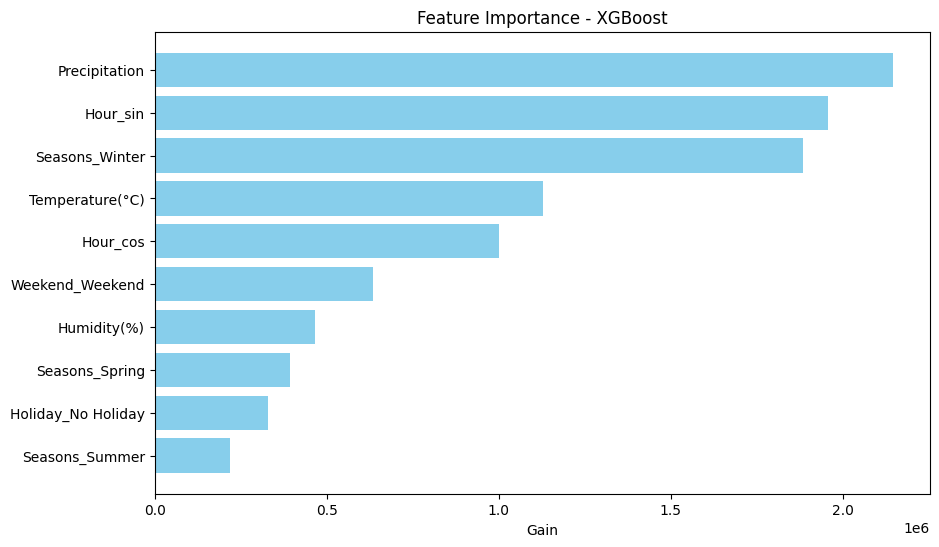

In [ ]:
# Ambil regressor dari pipeline
xgb_model = model_loaded.named_steps['regressor']

# Ambil preprocessing step
preprocessor = best_xgb.named_steps['preprocessor']

# Fitur numerik
num_features = numerical_features  # ['Temperature(°C)', 'Humidity(%)', 'Hour_sin', 'Hour_cos', 'Weekend', 'Precipitation']

# Fitur categorical (hasil OHE)
cat_features = preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(categorical_features)

# Gabungkan
feature_names = np.concatenate([num_features, cat_features])

# Dapatkan importance
importance = xgb_model.get_booster().get_score(importance_type='gain')

# Ubah menjadi list sesuai feature_names
importance_list = [importance.get(f'f{i}', 0) for i in range(len(feature_names))]

# Buat DataFrame untuk sorting
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'gain': importance_list
})

# Urutkan dari gain tertinggi ke terendah
importance_df = importance_df.sort_values(by='gain', ascending=True)  # ascending=True untuk plot horizontal

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['gain'], color='skyblue')
plt.xlabel('Gain')
plt.title('Feature Importance - XGBoost')
plt.show()
